# HIT140 – Foundations of Data Science  
## Assessment 3 | Linear Regression – Investigation A & B  
This notebook investigates the behavioural relationship between **bats** and **rats** using linear regression.  
- **Investigation A** focuses on behavioural predictors and feeding delay.  
- **Investigation B** compares seasonal patterns (Winter vs Spring) and examines how rat activity influences bat behaviour.

---


In [62]:
# ============================================================
# IMPORTING LIBRARIES
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.stats import proportion
import statsmodels.api as sm


## STEP 1: Load Datasets
We load the two datasets provided (`dataset1.csv` and `dataset2.csv`) containing information on bat and rat activity.  


In [63]:
BASE_DIR = os.getcwd()
df1 = pd.read_csv("../Datasets/dataset1.csv")
df2 = pd.read_csv("../Datasets/dataset2.csv")

print("Dataset 1 shape:", df1.shape)
print("Dataset 2 shape:", df2.shape)


Dataset 1 shape: (907, 12)
Dataset 2 shape: (2123, 7)


## STEP 2: Data Cleaning and Preparation
- Convert timestamp columns into datetime format.  
- Convert numerical columns into float type.  
- Handle missing values and replace numeric season codes with text labels.  
- Map months to readable names for visualisation.  


In [64]:
# Convert timestamps
for col in ['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time']:
    df1[col] = pd.to_datetime(df1[col], errors='coerce', dayfirst=True)
for col in ['time']:
    df2[col] = pd.to_datetime(df2[col], errors='coerce', dayfirst=True)

# Convert numeric fields
df1[['bat_landing_to_food','hours_after_sunset','seconds_after_rat_arrival']] = \
    df1[['bat_landing_to_food','hours_after_sunset','seconds_after_rat_arrival']].astype(float)
df2[['hours_after_sunset','bat_landing_number','food_availability','rat_minutes','rat_arrival_number']] = \
    df2[['hours_after_sunset','bat_landing_number','food_availability','rat_minutes','rat_arrival_number']].astype(float)

# Drop missing rows
df1.dropna(inplace=True)
df2.dropna(inplace=True)

# Replace numeric season codes with labels
df1['season'] = df1['season'].replace({0: 'Winter', 1: 'Spring'})

# Map months to names
month_map = {0:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun'}
df2['month_name'] = df2['month'].replace(month_map)

# Assign season by month
def assign_season(month):
    if month in [0,1,2,3]:
        return 'Winter'
    elif month in [4,5,6]:
        return 'Spring'
    else:
        return 'Unknown'
df2['season'] = df2['month'].apply(assign_season)

sns.set_style("whitegrid")


## INVESTIGATION A – Bat Behaviour and Rat Influence
We explore how bat feeding delay (`bat_landing_to_food`) is influenced by:
- Risk level
- Reward level
- Time after rat arrival

A multiple linear regression model is built, and evaluation metrics are computed.


In [65]:
X_A = df1[['risk', 'reward', 'seconds_after_rat_arrival']]
y_A = df1['bat_landing_to_food']

# Add constant for statsmodels
X_A_const = sm.add_constant(X_A)
modelA = sm.OLS(y_A, X_A_const).fit()
print(modelA.summary())


                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.060
Model:                             OLS   Adj. R-squared:                  0.057
Method:                  Least Squares   F-statistic:                     18.34
Date:                 Wed, 15 Oct 2025   Prob (F-statistic):           1.53e-11
Time:                         20:52:59   Log-Likelihood:                -4080.2
No. Observations:                  866   AIC:                             8168.
Df Residuals:                      862   BIC:                             8187.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

### Model Evaluation  
We split the dataset into 70% training and 30% testing data, then compute evaluation metrics:
- MAE, MSE, RMSE, NRMSE, and R²  


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
nrmse = rmse / (y_test.max() - y_test.min())
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f} | MSE: {mse:.3f} | RMSE: {rmse:.3f} | NRMSE: {nrmse:.3f} | R²: {r2:.3f}")


MAE: 12.968 | MSE: 888.022 | RMSE: 29.800 | NRMSE: 0.108 | R²: 0.028


### Multicollinearity and Feature Importance
We calculate the Variance Inflation Factor (VIF) to detect multicollinearity and display coefficients.


In [67]:
vif = pd.DataFrame({
    "Variable": X_A.columns,
    "VIF": [variance_inflation_factor(X_A.values, i) for i in range(X_A.shape[1])]
})
display(vif)

importance = pd.DataFrame({
    'Variable': X_A_const.columns,
    'Coefficient': modelA.params
}).sort_values(by='Coefficient', ascending=False)
display(importance)


,Variable,VIF
0,risk,1.512269
1,reward,1.511505
2,seconds_after_rat_arrival,2.127080


,Variable,Coefficient
risk,risk,19.170187
reward,reward,13.869825
seconds_after_rat_arrival,seconds_after_rat_arrival,0.003096
const,const,-6.696127


### Assumption Checks
Residual plots test **linearity**, **homoscedasticity**, and **normality**.


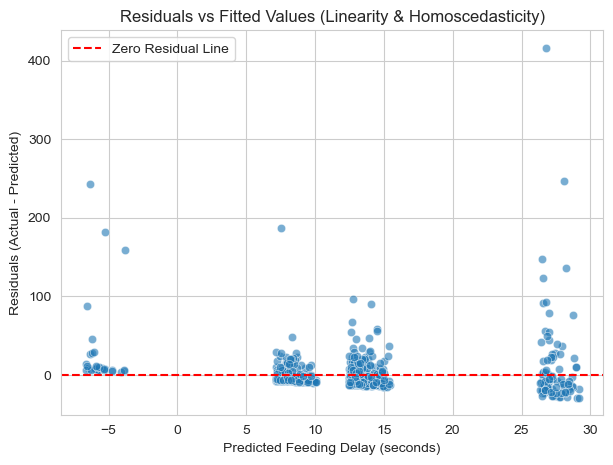

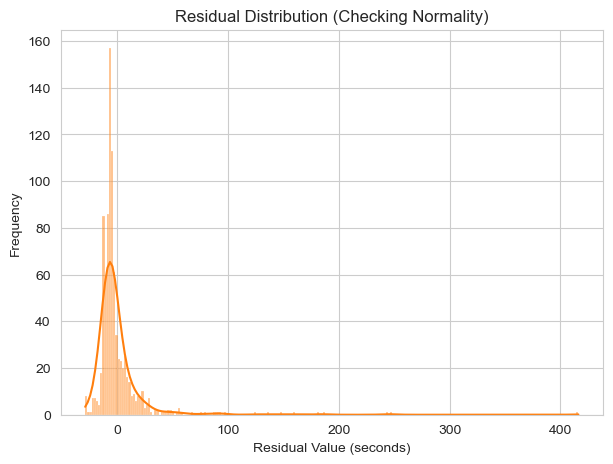

In [68]:
fitted_values = modelA.predict(X_A_const)
residuals = y_A - fitted_values

# Linearity and Homoscedasticity
plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Residuals vs Fitted Values (Linearity & Homoscedasticity)")
plt.xlabel("Predicted Feeding Delay (seconds)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.show()

# Normality
plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, color='#ff7f0e')
plt.title("Residual Distribution (Checking Normality)")
plt.xlabel("Residual Value (seconds)")
plt.ylabel("Frequency")
plt.show()


## INVESTIGATION B – Seasonal Comparison
We compare:
- Risk-taking behaviour
- Feeding delay
- Rat and bat activity per month  
and analyse seasonal regressions and correlations.


season
Spring    0.501377
Winter    0.607143
Name: risk, dtype: float64
season
Spring    13.142006
Winter     5.214164
Name: bat_landing_to_food, dtype: float64
            rat_arrival_number  bat_landing_number
month_name                                        
Apr                   0.569707           34.586919
Dec                   0.108974           28.044872
Feb                   0.365079           42.421769
Jan                   0.113074           32.734982
Jun                   0.000000           40.666667
Mar                   0.166667           37.727273
May                   0.735521           19.696911


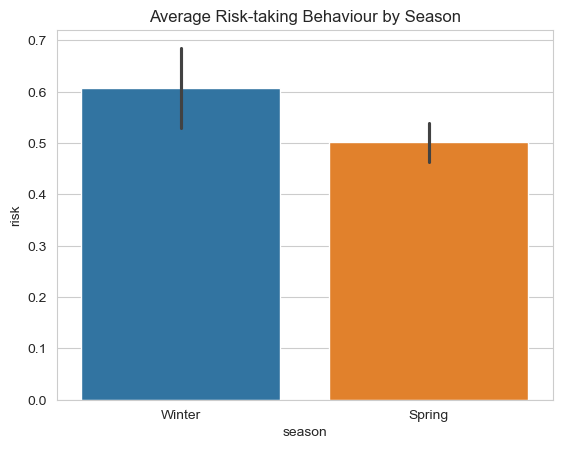

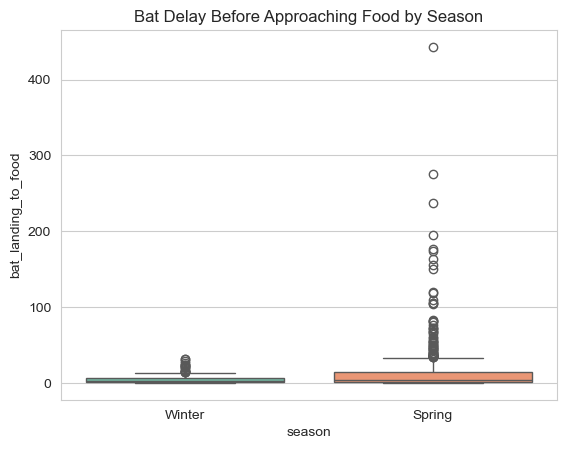

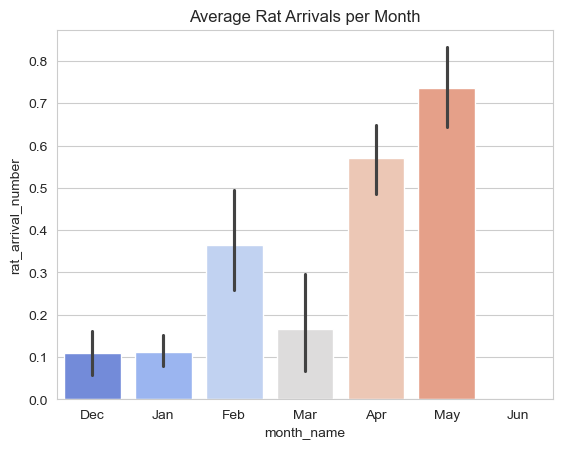

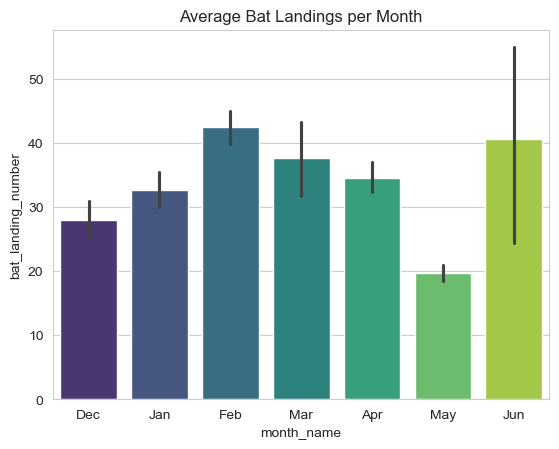

In [69]:
# Descriptive statistics
print(df1.groupby('season')['risk'].mean())
print(df1.groupby('season')['bat_landing_to_food'].mean())
print(df2.groupby('month_name')[['rat_arrival_number','bat_landing_number']].mean())

# Seasonal visualisations
sns.barplot(x='season', y='risk', hue='season', data=df1,
            palette={'Winter':'#1f77b4','Spring':'#ff7f0e'}, legend=False)
plt.title("Average Risk-taking Behaviour by Season")
plt.show()

sns.boxplot(x='season', y='bat_landing_to_food', hue='season', data=df1,
            palette={'Winter':'#66c2a5','Spring':'#fc8d62'}, legend=False)
plt.title("Bat Delay Before Approaching Food by Season")
plt.show()

sns.barplot(x='month_name', y='rat_arrival_number', hue='month_name', data=df2,
            palette='coolwarm', legend=False)
plt.title("Average Rat Arrivals per Month")
plt.show()

sns.barplot(x='month_name', y='bat_landing_number', hue='month_name', data=df2,
            palette='viridis', legend=False)
plt.title("Average Bat Landings per Month")
plt.show()


### Inferential Tests
We use:
- **t-test** to compare feeding delay between seasons  
- **Proportion test** to compare risk-taking behaviour


In [70]:
delay_winter = df1[df1['season']=='Winter']['bat_landing_to_food']
delay_spring = df1[df1['season']=='Spring']['bat_landing_to_food']
t_stat, p_val = stats.ttest_ind(delay_winter, delay_spring, equal_var=False)
print(f"T-test result: t={t_stat:.3f}, p={p_val:.5f}")

winter_risk = df1[df1['season']=='Winter']['risk']
spring_risk = df1[df1['season']=='Spring']['risk']
count_winter, n_winter = winter_risk.sum(), len(winter_risk)
count_spring, n_spring = spring_risk.sum(), len(spring_risk)
ci_winter = proportion.proportion_confint(count_winter, n_winter, alpha=0.05, method='normal')
ci_spring = proportion.proportion_confint(count_spring, n_spring, alpha=0.05, method='normal')
print("95% Confidence Intervals for Risk-taking:")
print("Winter:", ci_winter)
print("Spring:", ci_spring)


T-test result: t=-6.287, p=0.00000
95% Confidence Intervals for Risk-taking:
Winter: (0.5262431694401958, 0.6880425448455184)
Spring: (0.4650070054746132, 0.5377478154620258)


### Seasonal Linear Regression Comparison  
We build separate regression models for **Winter** and **Spring** to compare bat–rat interaction patterns.


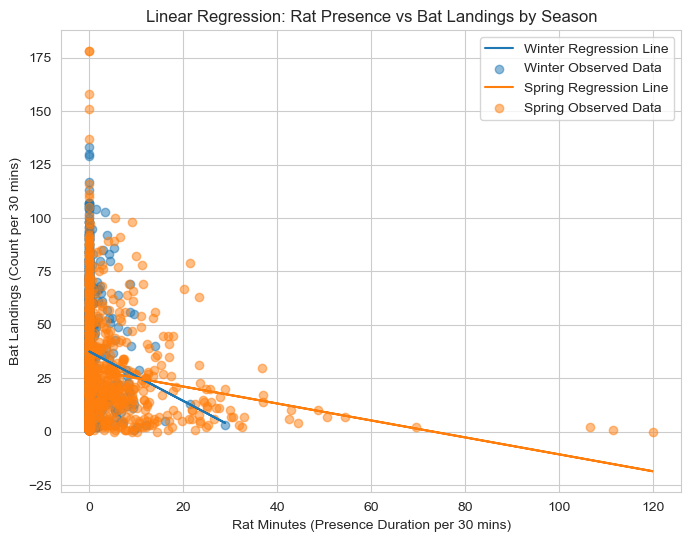

In [71]:
plt.figure(figsize=(8,6))
colors = {'Winter':'#1f77b4', 'Spring':'#ff7f0e'}

for season, color in colors.items():
    df_season = df2[df2['season']==season]
    X = df_season[['rat_minutes']]
    y = df_season['bat_landing_number']
    model = LinearRegression().fit(X, y)
    plt.plot(X, model.predict(X), color=color, label=f'{season} Regression Line')
    plt.scatter(X, y, color=color, alpha=0.5, label=f'{season} Observed Data')

plt.title("Linear Regression: Rat Presence vs Bat Landings by Season")
plt.xlabel("Rat Minutes (Presence Duration per 30 mins)")
plt.ylabel("Bat Landings (Count per 30 mins)")
plt.legend()
plt.show()


### Correlation by Month
We calculate correlation between **rat presence** and **bat landings** for each month, skipping months with no variation.


In [72]:
print("Correlation Between Rat Minutes and Bat Landings (per Month):")
for m in df2['month_name'].unique():
    subset = df2[df2['month_name'] == m]
    if len(subset) > 2:
        if subset['rat_minutes'].nunique() > 1 and subset['bat_landing_number'].nunique() > 1:
            corr, p = stats.pearsonr(subset['rat_minutes'], subset['bat_landing_number'])
            print(f"{m}: correlation={corr:.3f}, p-value={p:.5f}")
        else:
            print(f"{m}: correlation not defined (one variable is constant)")


Correlation Between Rat Minutes and Bat Landings (per Month):
Dec: correlation=-0.027, p-value=0.73721
Jan: correlation=-0.041, p-value=0.49267
Feb: correlation=-0.162, p-value=0.00064
Mar: correlation=-0.084, p-value=0.33767
Apr: correlation=-0.178, p-value=0.00002
May: correlation=-0.144, p-value=0.00105
Jun: correlation not defined (one variable is constant)


### Regression Performance Summary
We compare model performance (R² and RMSE) between Winter and Spring.


In [14]:
winter_df = df2[df2['season']=='Winter']
spring_df = df2[df2['season']=='Spring']

X_winter = winter_df[['hours_after_sunset','rat_minutes','food_availability']]
y_winter = winter_df['bat_landing_number']
X_spring = spring_df[['hours_after_sunset','rat_minutes','food_availability']]
y_spring = spring_df['bat_landing_number']

lr_winter = LinearRegression().fit(X_winter, y_winter)
lr_spring = LinearRegression().fit(X_spring, y_spring)

r2_winter = r2_score(y_winter, lr_winter.predict(X_winter))
r2_spring = r2_score(y_spring, lr_spring.predict(X_spring))
rmse_winter = np.sqrt(mean_squared_error(y_winter, lr_winter.predict(X_winter)))
rmse_spring = np.sqrt(mean_squared_error(y_spring, lr_spring.predict(X_spring)))

print(f"Winter: R²={r2_winter:.3f}, RMSE={rmse_winter:.3f}")
print(f"Spring: R²={r2_spring:.3f}, RMSE={rmse_spring:.3f}")


Winter: R²=0.027, RMSE=25.830
Spring: R²=0.043, RMSE=23.730


## FINAL SUMMARY

- **Winter:** Fewer rats, predictable bat feeding patterns.  
- **Spring:** More rats, higher variability, cautious bat behaviour.  
- **Correlation:** Mostly negative between rat and bat activity.  
- **Conclusion:** Bats adjust their feeding behaviour based on rat activity, showing avoidance patterns when rats are more active.
